In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelagem
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import preprocessing

sns.set()

In [139]:
safra2018 = pd.read_csv('Safra_2018-2019.csv')
safra2020 = pd.read_csv('Safra_2020.csv')

 # Solução para modelagem do uso de pesticidas nas safras agrícolas

# Descrição dos dados e do problema. Análise exploratória.

O conjunto de dados em questão se refere ao final da safra de 2018 e 2019, onde foram coletadas frequências de manejamento de pesticidas e outros fatores técnicos-agrícolas 

A questão principal, ignorando fatores climáticos e técnicos-agrícolas, é como o manejamento de pesticidas pode criar danos ou beneficiar a plantação. Além disso a modelagem apresentada deve tornar possível prever danos e benefícios para dados fora do conjunto
(referência README do repositório dos dados). 

In [52]:
safra2018.head()

,Unnamed: 0,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
0,0,SCROP00001,188,1,0,1,0,0.0,0,1,0
1,1,SCROP00002,209,1,0,1,0,0.0,0,2,1
2,2,SCROP00003,257,1,0,1,0,0.0,0,2,1
3,3,SCROP00004,257,1,1,1,0,0.0,0,2,1
4,4,SCROP00005,342,1,0,1,0,0.0,0,2,1


Examinando as variáveis características notamos que há uma relação pré-definida entre variáveis que registram o uso de pesticidas. Notamos que é possível verificar erros de registro dos dados entre as seguintes variáveis:

  - Registros com 0 'Doses_Semana' não podem ter sofrido danos por uso de pesticida ('dano_na_plantacao' igual a 2).
  - Registros com 0.0 'Semanas_Utilizando' não podem ter sofrido danos por uso de pesticida.
  - Registros com 'Categoria_Pesticida' igual a 1 (nunca usou pesticida) não podem ter sofrido danos por uso de pesticida.
  
Podemos ver abaixo que há uma quantidade mínima desses erros de registro.

In [53]:
print(len(safra2018[(safra2018['Doses_Semana']==0) & (safra2018['dano_na_plantacao']==2)]))
print(len(safra2018[(safra2018['Semanas_Utilizando']==0.0) & (safra2018['dano_na_plantacao']==2)]))
print(len(safra2018[(safra2018['Categoria_Pesticida']==1) & (safra2018['dano_na_plantacao']==2)]))

150
126
150


## Limpeza do conjunto de dados 

Contamos o número de registros errados NA:

In [54]:
# Duas formas de verificar a existência de NAs no dataset 
safra2018.count()
safra2018.isna().sum()

Unnamed: 0                     0
Identificador_Agricultor       0
Estimativa_de_Insetos          0
Tipo_de_Cultivo                0
Tipo_de_Solo                   0
Categoria_Pesticida            0
Doses_Semana                   0
Semanas_Utilizando          8055
Semanas_Sem_Uso                0
Temporada                      0
dano_na_plantacao              0
dtype: int64

Retiramos os dados com registros errados e com entradas NaNs (not a number):

In [55]:
safra2018.dropna(axis=0,inplace=True)
print(safra2018.shape)

(71945, 11)


Retiramos os erros de registros devidos aos fatores citados acima sobre os campos 'Doses_Semana', 'Semanas_Utilizando', 'Categoria_Pesticida':

In [56]:
safra2018 = safra2018[(safra2018['Doses_Semana']!=0) | (safra2018['dano_na_plantacao']!=2)]
safra2018 = safra2018[(safra2018['Semanas_Utilizando']!=0.0) | (safra2018['dano_na_plantacao']!=2)]
safra2018 = safra2018[(safra2018['Categoria_Pesticida']!=1) | (safra2018['dano_na_plantacao']!=2)]

In [57]:
print(safra2018.shape)

(71819, 11)


Retiramos o campo 'Temporada', por ser uma assumpção da modelagem (referência README), retiramos o campo que apenas repete os indices:

In [58]:
safra2018 = safra2018.drop(['Unnamed: 0','Temporada'],axis=1)
safra2018.head()

,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,dano_na_plantacao
0,SCROP00001,188,1,0,1,0,0.0,0,0
1,SCROP00002,209,1,0,1,0,0.0,0,1
2,SCROP00003,257,1,0,1,0,0.0,0,1
3,SCROP00004,257,1,1,1,0,0.0,0,1
4,SCROP00005,342,1,0,1,0,0.0,0,1


## Representatividade das categorias de 'dano_na_plantacao'

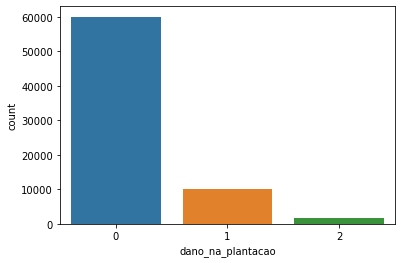

In [67]:
sns.countplot(x='dano_na_plantacao',data=safra2018)

As categorias que designam os danos na safra não estão igualmente representadas no conjunto de dados. Isso dificulta o uso de alguns classificadores pois irão identificar melhor as características da categoria com maior representatividade. Será necessário usar métodos de balanceamento dos dados e métricas que levem em conta o desbalanceamento.

## Representatividade do tipo de cultivo e solo em relação aos danos na plantação

In [59]:
safra2018.groupby(['Tipo_de_Cultivo'])['dano_na_plantacao'].value_counts(normalize=True)

Tipo_de_Cultivo  dano_na_plantacao
0                0                    0.829144
                 1                    0.146090
                 2                    0.024765
1                0                    0.851395
                 1                    0.125500
                 2                    0.023105
Name: dano_na_plantacao, dtype: float64

In [60]:
safra2018.groupby(['Tipo_de_Solo'])['dano_na_plantacao'].value_counts(normalize=True)

Tipo_de_Solo  dano_na_plantacao
0             0                    0.827030
              1                    0.147015
              2                    0.025954
1             0                    0.845405
              1                    0.132270
              2                    0.022325
Name: dano_na_plantacao, dtype: float64

É possível verificar que o tipo do cultivo e tipo de solo, características técnicas-agrícolas, possuem uma diferença de menos de 0.5% no dano devido ao uso de pesticidas (2). Sua influência é maior nas plantações sem danos ou com outros danos diversos. Seguimos então a sugestão de não levar em conta esses campos na modelagem e análise (README)

In [61]:
safra2018 = safra2018.drop(['Tipo_de_Solo','Tipo_de_Cultivo'],axis=1)

## Relevância do uso de pesticidas em relação aos danos na plantação

O campo 'Categoria_Pesticida' (1 - Nunca Usou, 2 - Já Usou, 3 - Está Usando) pode nos dar um panorama da relevância do uso de pesticidas e sua influência na safra.

In [62]:
safra2018.groupby(['Categoria_Pesticida'])['dano_na_plantacao'].value_counts(normalize=True)

Categoria_Pesticida  dano_na_plantacao
1                    1                    0.828780
                     0                    0.171220
2                    0                    0.892964
                     1                    0.096255
                     2                    0.010782
3                    0                    0.705941
                     1                    0.234396
                     2                    0.059663
Name: dano_na_plantacao, dtype: float64

Vemos que, por um lado, quem está usando pesticidas enfrenta mais problemas na plantação do que quem usou no passado. Por outro lado quem nunca usou tem a safra quase inteira prejudicada por outros fatores ('dano_na_plantacao' = 1 tem frequência de 83%).

Portanto é racional esperar que quem usa pesticida com alguma frequência irá ter safras melhores do que quem nunca usou.

## Frequência de uso de pesticidas e os danos na plantação

As características **'Doses_Semana'**, **'Semanas_Utilizando'** e **'Semanas_Sem_Uso'** devem possuir diferentes influências no resultado da safra, examinemos suas distribuições.

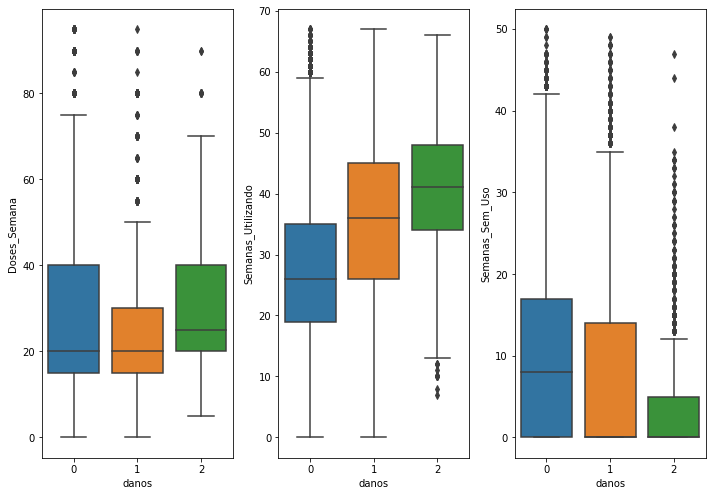

In [66]:
fields = {'Doses_Semana','Semanas_Utilizando','Semanas_Sem_Uso'}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 7))

for idx, pest_use in enumerate(fields):
    ax = axes[idx]
    sns.boxplot(x='dano_na_plantacao', y=pest_use, data=safra2018, ax=ax)
    ax.set_xlabel('danos')
    ax.set_ylabel(pest_use)
fig.tight_layout()

As distribuições em relações aos diferentes tipos de danos tem clara diferença para as features **'Semanas_Utilizando'** e **'Semanas_Sem_Uso'**.

# Modelagem, Random Forest com SMOTE

Aplico técnica de reamostragem artificial, SMOTE, para balancear o conjunto de dados igualmente entre as classes. 

In [110]:
oversample = SMOTE()
safra = safra2018.drop(['Identificador_Agricultor','dano_na_plantacao'],axis=1)
X,y=oversample.fit_resample(safra, safra2018['dano_na_plantacao'])

In [124]:
print('Antes do SMOTE {}'.format(safra.shape))
print('Após aplicação do SMOTE {}'.format(X.shape))

Antes do SMOTE (71819, 5)
Após aplicação do SMOTE (179997, 5)


Escolho o classificador de Random Forest devido a possibilidade de interpretabilidade de seus resultados (calcularemos a importância das Features abaixo).

A escolha do melhor modelo no espaço de parametros é feita através de cross-validação do dataset e comparação da métrica F1 para modelos multiclasses (F1-macro).

In [112]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, class_weight='balanced')

In [113]:
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}

In [117]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
rf_grid_search = GridSearchCV(rf, parameters, n_jobs=-1, scoring='f1_macro', cv=skf, verbose=True)
rf_grid_search = rf_grid_search.fit(X, y)
print('Pontuação Melhor Modelo {}'.format(rf_grid_search.best_score_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  8.1min finished


Pontuação Melhor Modelo 0.7473964604876322


## Importância das Features

O modelo de Random Forests permite determinar a importância de cada Feature implicada na modelagem.

In [119]:
nomes_colunas = [x for x in safra]

In [123]:
pd.DataFrame({'features': nomes_colunas,
              'coef': rf_grid_search.best_estimator_.feature_importances_}).sort_values(by='coef', ascending=False)


,features,coef
3,Semanas_Utilizando,0.490314
0,Estimativa_de_Insetos,0.196292
2,Doses_Semana,0.165382
4,Semanas_Sem_Uso,0.105916
1,Categoria_Pesticida,0.042097


# Predição das Safras de 2020

In [140]:
safra2020=safra2020.drop(['Unnamed: 0','Identificador_Agricultor','Temporada','Tipo_de_Cultivo','Tipo_de_Solo'],axis=1)
safra2020.dropna(axis=0,inplace=True)

In [141]:
y_pred=rf_grid_search.predict(safra2020)

In [143]:
safra2020['dano_na_plantacao'] = y_pred

In [148]:
safra2020.to_csv('safra2020pred.csv')

A predição pode ser comparada através das distribuições das Features nas safras de 2020. Observo que o modelo captura o comportamento das distribuições das Features, através da predição, sendo assim mais uma evidência que o modelo de Random Forest é um bom modelo para os dados.

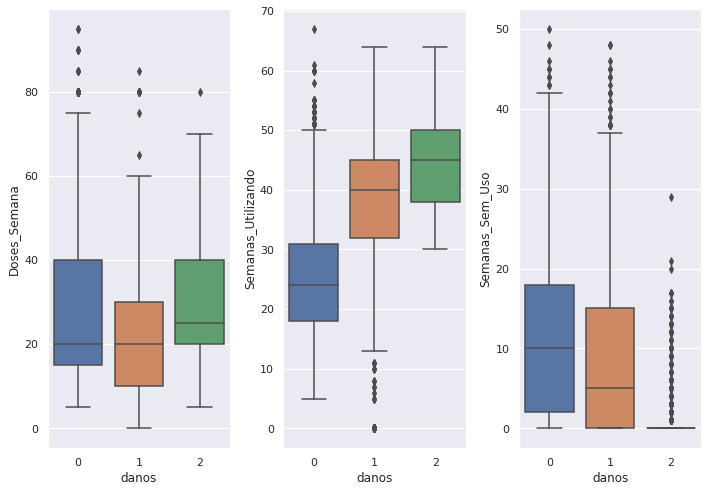

In [150]:
fields = {'Doses_Semana','Semanas_Utilizando','Semanas_Sem_Uso'}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 7))

for idx, pest_use in enumerate(fields):
    ax = axes[idx]
    sns.boxplot(x='dano_na_plantacao', y=pest_use, data=safra2020, ax=ax)
    ax.set_xlabel('danos')
    ax.set_ylabel(pest_use)
fig.tight_layout()

# Conclusões

 - Através da análise exploratória pudemos conferir que as técnicas de solo, cultivo e climáticas não influenciam no controle de uso dos pesticidas.
 - O uso dos pesticidas melhoram as safras em relação ao não uso.
 - Segundo o modelo, o número de semanas utilizando é o fator mais importante para uso de pesticidas. 
 - A visualização das distribuições nos dá uma previsão de ~18-30 semanas de uso de pesticidas para os melhores resultados na safra de 2020. 
 - O modelo ainda nos responde positivimente a intuição que a estimativa do número de insetos é importante, de fato é o segundo fator mais importante. 